# Supplemental

This notebook will hold more of the ad-hoc elements that occurred from the non-linear, iterative approach that occurred during this project.  It is laid out in sections, but there could be references between various notebooks, pieces of information, and results as some of these items were happening in parallel.  But I wanted to capture this information as a reference to the process that was performed, and is provided 'as-is'.

## **NOTE: This notebook is not mean to be run**

In [ ]:
break this to save the data below

In [105]:
# Default Random Forest Section
# Cross Val Scores

# univariate k=10 0.8432162405586082
# univariate features only: 0.8295174072016502
# after 0.8460311597845791
# before dropping on_hold_mins 0.8452802945529363
#cross_val_score(rf, X_train, y_train).mean()

0.8452802945529363

In [106]:
# Default Random Forest Section
# model scores rf.score Train, test

# univariate k=10             (0.9997185212985551, 0.8435272045028143)
# univariate features only    (0.988647025708388, 0.8341463414634146)
# after dropping on_hold_mins (0.9999061737661851, 0.8472795497185741)
# before dropping on_hold_mins (0.99981234753237, 0.8480300187617261)
# rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.99981234753237, 0.8480300187617261)

## Imbalanced Class Investigation

After the first pass through modeling, it appears that the model isn't having much predictive power.  There could be a number of factors, such as class imbalance, lack of data, or features that don't explain the target.  To try and understand which issue that may be causing the lack of predictive power, I will try and re-work the data so that the class is balanced and see how the model performs at that point.  That will give me some information as to which issue or area I should focus on.  

### Manual Sampling

Before reaching to an approach like SMOTE, run through some early tests by undersampling the majority class to create various balances and see how a model would perform, or if I could find some clues as to if the model was truly just suffereing from class imbalance, or if something else was going on. 

In [488]:
# manual resample with real data
# the sample amounts were changed to create 50/50, 60/40, or 70/30 balances 
# and the affects of those changes were noted

# randomly sample majority class ticket data
good = (
    tickets
    [tickets['sat_score'] == 1]
    .sample(2800)
)

# randomly sample minority class ticket data
bad = (
    tickets
    [tickets['sat_score'] == 0]
    .sample(1200)
)

# reassemble to a single data frame
df = pd.concat([good, bad])
df['sat_score'].value_counts()

1    2800
0    1200
Name: sat_score, dtype: int64

#### Train/Test Split

In [489]:
X = df.drop(columns=['sat_score'])
y = df['sat_score']

In [491]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   stratify=y,
                                                   random_state=415)

#### Check Shape and Class Breakdown

In [492]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3200, 10), (800, 10), (3200,), (800,))

In [493]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.7
 0    0.3
 Name: sat_score, dtype: float64,
 1    0.7
 0    0.3
 Name: sat_score, dtype: float64)

#### Run and Evaluate Model

Since I dropped the channel feature for this exercise, all the remaining features should be numerical and can be modeled.  I will try the random forest model with the parameters from the first gridsearch to see how that works with this data.

In [343]:
# {'rf__bootstrap': True,
#  'rf__criterion': 'entropy',
#  'rf__max_depth': 15,
#  'rf__max_features': 3,
#  'rf__min_samples_leaf': 6,
#  'rf__n_estimators': 25,
#  'rf__warm_start': True}

# changing to below params from 50/50 GS
# {'rf__bootstrap': True,
#  'rf__criterion': 'entropy',
#  'rf__max_depth': 20,
#  'rf__max_features': 20,
#  'rf__min_samples_leaf': 10,
#  'rf__n_estimators': 25,
#  'rf__warm_start': True}

# params from 9 hour GS on full data:
# {'rf__bootstrap': True,
#  'rf__criterion': 'gini',
#  'rf__max_depth': 95,
#  'rf__max_features': 4,
#  'rf__min_samples_leaf': 5,
#  'rf__n_estimators': 175,
#  'rf__warm_start': True}

rf_downsample = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_depth=95,
    max_features=4,
    min_samples_leaf=5,
    n_estimators=175,
    warm_start=True
)

In [344]:
rf_downsample.fit(X_train, y_train)

RandomForestClassifier(max_depth=95, max_features=4, min_samples_leaf=5,
                       n_estimators=175, warm_start=True)

In [345]:
rf_downsample.score(X_train, y_train), rf_downsample.score(X_test, y_test)

# before additional feature engineering: (0.88125, 0.6)
# after (added reply and comment rates) (0.85, 0.6025)
# 60/40 manual resample after feat eng: (0.855, 0.648)
# 50/50 univariate k=4 feats only: (0.8848958333333333, 0.55625)

(0.8848958333333333, 0.55625)

In [346]:
print(classification_report(y_test, 
                            rf_downsample.predict(X_test)
                           ))

# univariate k=4 feats only
#               precision    recall  f1-score   support

#            0       0.56      0.57      0.56       240
#            1       0.56      0.55      0.55       240

#     accuracy                           0.56       480
#    macro avg       0.56      0.56      0.56       480
# weighted avg       0.56      0.56      0.56       480



              precision    recall  f1-score   support

           0       0.56      0.57      0.56       240
           1       0.56      0.55      0.55       240

    accuracy                           0.56       480
   macro avg       0.56      0.56      0.56       480
weighted avg       0.56      0.56      0.56       480



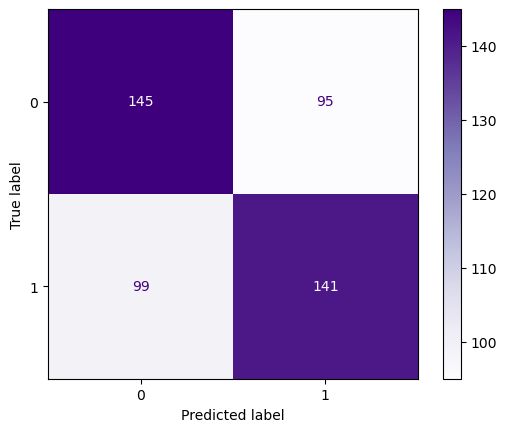

In [177]:
# from 50/50 undersampled data using params from original gridsearch
ConfusionMatrixDisplay.from_estimator(rf_downsample, X_test, y_test,
                                     cmap='Purples');

Using a 50/50 split between the classes, and just the parameters from the gridsearch from the imbalanced data test, it does look like there might be some predictive power here.  Trying a quick gridsearch to see how much of a difference that may make.

#### GridSearch

This section represents a slight change in approach.  What you will see in this section are results from some initial feature selection using Univariate Feature Selection, at first somewhat incorrectly by using a k=4 value and only choosing 4 features, then again with k=10 with 10 features.  With this information, the process was:
* Manually sample the data (done using code from above)
* Run a quick grid search using that data and feature set
* Score the model with the sampled data
* Print a classification report for that model with the sampled data
* Run through identical process again to attempt with a new sample, with the same class balance
    * i.e. `50/50 univariate #2` would indicate a second attempt with the same balance

In [456]:
# configure pipeline
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# Attempt for class investigation
# univariate k=4 (forgot to save previous)
# rf_params = {
#     'rf__n_estimators': np.arange(25, 200, 15),
#     'rf__criterion' : ["gini", "entropy"],
#     'rf__max_depth': np.arange(10, 100, 10),
#     'rf__min_samples_leaf': np.arange(5, 11),
#     'rf__bootstrap': [True],
#     'rf__warm_start': [True],
#     'rf__max_features': ['sqrt', 2, 3, 4, 5]
# }

# univariate k=10
rf_params = {
    'rf__n_estimators': np.arange(25, 200, 15),
    'rf__criterion' : ["gini", "entropy"],
    'rf__max_depth': np.arange(10, 100, 10),
    'rf__min_samples_leaf': np.arange(5, 11),
    'rf__bootstrap': [True],
    'rf__warm_start': [True],
    'rf__max_features': ['sqrt', 3, 5, 7, 9]
}

In [457]:
# commenting out so notebook can be run
gs = GridSearchCV(rf_pipe, rf_params, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
gs.best_params_

# attempt with univariate k=10 18m
# Fitting 5 folds for each of 6480 candidates, totalling 32400 fits

# {'rf__bootstrap': True,
#  'rf__criterion': 'gini',
#  'rf__max_depth': 20,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_leaf': 10,
#  'rf__n_estimators': 115,
#  'rf__warm_start': True}

# attempt with univariate k=4 only features 15m (0.8588541666666667, 0.5583333333333333)
# Fitting 5 folds for each of 6480 candidates, totalling 32400 fits

# {'rf__bootstrap': True,
#  'rf__criterion': 'entropy',
#  'rf__max_depth': 30,
#  'rf__max_features': 5,
#  'rf__min_samples_leaf': 6,
#  'rf__n_estimators': 70,
#  'rf__warm_start': True}

# attempt 2 after feat eng 33:27 (0.845, 0.6225)
# Fitting 5 folds for each of 9720 candidates, totalling 48600 fits

# {'rf__bootstrap': True,
#  'rf__criterion': 'entropy',
#  'rf__max_depth': 20,
#  'rf__max_features': 20,
#  'rf__min_samples_leaf': 10,
#  'rf__n_estimators': 25,
#  'rf__warm_start': True}

# attempt 1 (0.856875, 0.5925)
# Fitting 5 folds for each of 9720 candidates, totalling 48600 fits 33:31

# {'rf__bootstrap': True,
#  'rf__criterion': 'log_loss',
#  'rf__max_depth': 40,
#  'rf__max_features': 5,
#  'rf__min_samples_leaf': 9,
#  'rf__n_estimators': 70,
#  'rf__warm_start': True}

Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


{'rf__bootstrap': True,
 'rf__criterion': 'gini',
 'rf__max_depth': 20,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 10,
 'rf__n_estimators': 115,
 'rf__warm_start': True}

In [494]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

# univariate k=10 70/30 #2 
# univariate k=10 70/30 #1 (0.6415625, 0.615)
# univariate k=10 60/40 #2 (0.64875, 0.63)
# univariate k=10 60/40 #1 (0.6316666666666667, 0.6033333333333334)
# univariate k=10 50/50 #2 (0.6453125, 0.6708333333333333)
# univariate k=10 50/50 #1 (0.78125, 0.5791666666666667)
# univariate 70/30 #1 (0.609375, 0.63375)
# univariate 60/40 #3 (0.6379166666666667, 0.6216666666666667)
# univariate 60/40 #2 (0.6325, 0.6116666666666667)
# univariate 60/40 (0.8588541666666667, 0.5583333333333333)
# univariate 50/50 (0.8588541666666667, 0.5583333333333333)

(0.6415625, 0.615)

In [495]:
cross_val_score(gs.best_estimator_, X_train, y_train).mean()

# univariate k=10 70/30 #2 
# univariate k=10 70/30 #1 0.6953125000000001
# univariate k=10 60/40 #2 0.6179166666666667
# univariate k=10 60/40 #1 0.6258333333333332
# univariate k=10 50/50 #2 0.584375
# univariate k=10 50/50 #1 0.609375
# univariate 70/30 #1 0.6853125
# univariate 60/40 #3 0.6125
# univariate 60/40 #2 0.5974999999999999

0.6953125000000001

In [496]:
# univariate k=10 70/30 #1
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.41      0.66      0.51       240
           1       0.80      0.59      0.68       560

    accuracy                           0.61       800
   macro avg       0.61      0.63      0.60       800
weighted avg       0.69      0.61      0.63       800



In [487]:
# univariate k=10 60/40 #2
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.53      0.63      0.58       240
           1       0.72      0.63      0.67       360

    accuracy                           0.63       600
   macro avg       0.63      0.63      0.62       600
weighted avg       0.64      0.63      0.63       600



In [478]:
# univariate k=10 60/40 #1 
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.50      0.63      0.56       240
           1       0.70      0.59      0.64       360

    accuracy                           0.60       600
   macro avg       0.60      0.61      0.60       600
weighted avg       0.62      0.60      0.61       600



In [469]:
# univariate k=10 50/50 #2 
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.66      0.69      0.68       240
           1       0.68      0.65      0.66       240

    accuracy                           0.67       480
   macro avg       0.67      0.67      0.67       480
weighted avg       0.67      0.67      0.67       480



In [460]:
# univariate k=10 50/50 #1
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.58      0.57      0.58       240
           1       0.58      0.59      0.58       240

    accuracy                           0.58       480
   macro avg       0.58      0.58      0.58       480
weighted avg       0.58      0.58      0.58       480



In [406]:
# univariate 70/30 #1
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.43      0.70      0.53       240
           1       0.82      0.61      0.70       560

    accuracy                           0.63       800
   macro avg       0.63      0.65      0.62       800
weighted avg       0.71      0.63      0.65       800



In [378]:
# 60/40 w/Univariate only #3
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.52      0.71      0.60       240
           1       0.75      0.56      0.64       360

    accuracy                           0.62       600
   macro avg       0.63      0.64      0.62       600
weighted avg       0.66      0.62      0.62       600



In [367]:
# 60/40 w/Univariate only #2
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.51      0.75      0.61       240
           1       0.76      0.52      0.61       360

    accuracy                           0.61       600
   macro avg       0.63      0.64      0.61       600
weighted avg       0.66      0.61      0.61       600



In [359]:
# 60/40 w/Univariate only
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.54      0.74      0.62       240
           1       0.77      0.57      0.66       360

    accuracy                           0.64       600
   macro avg       0.65      0.66      0.64       600
weighted avg       0.68      0.64      0.64       600



In [350]:
# 50/50 w/Univariate only
print(classification_report(y_test, 
                            gs.predict(X_test)
                           ))

              precision    recall  f1-score   support

           0       0.55      0.59      0.57       240
           1       0.56      0.53      0.54       240

    accuracy                           0.56       480
   macro avg       0.56      0.56      0.56       480
weighted avg       0.56      0.56      0.56       480



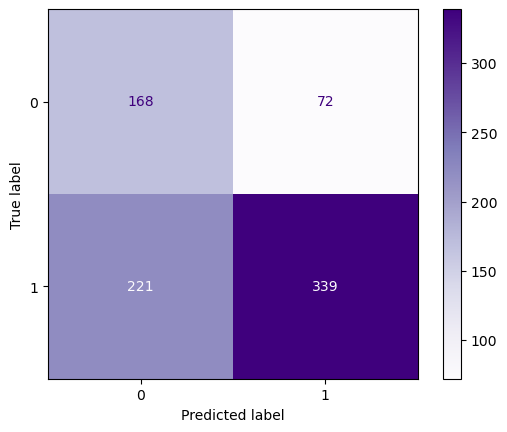

In [407]:
# univariate 70/30 #1
ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test, y_test,
                                     cmap='Purples');

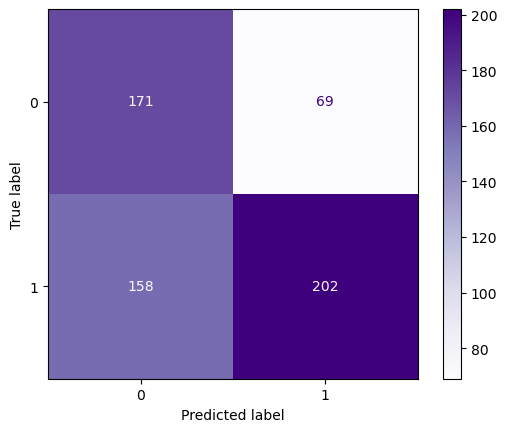

In [379]:
# from 60/40 univariate #3
ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test, y_test,
                                     cmap='Purples');

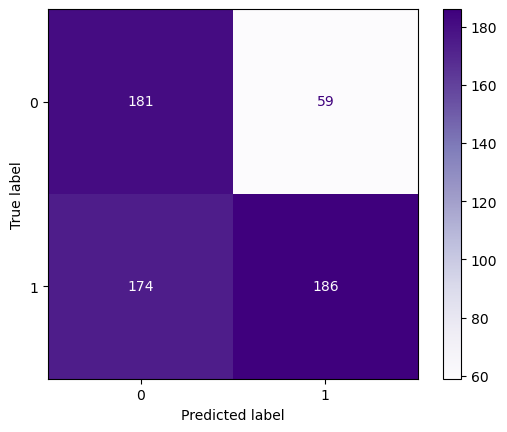

In [368]:
# from 60/40 univariate #2 
ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test, y_test,
                                     cmap='Purples');

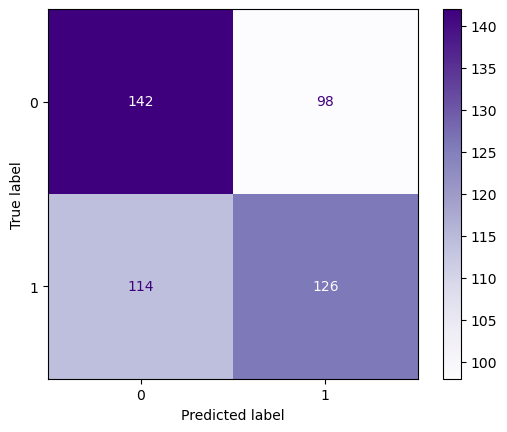

In [351]:
# from 50/50 undersampled data using params from original gridsearch
ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test, y_test,
                                     cmap='Purples');

In [92]:
pd.DataFrame(
    gs.best_estimator_.named_steps.rf.feature_importances_,
    X.columns
).reset_index().sort_values(by=0, ascending=False)

,index,0
10,sent_score,0.143880
14,rply_rate,0.116227
7,agt_wait_mins,0.095280
8,reqstr_wait_mins,0.088659
15,comm_rate,0.085781
6,full_reso_mins,0.083426
5,first_reso_mins,0.080270
4,reply_mins,0.077709
13,td_assnd_slvd,0.076962
12,td_crtd_assnd,0.075463


#### Results Summary

As I was stepping through the balances (50/50, 60/40, etc.) the performance at 50/50 was generally the best.  The metrics were showing that even using the same split but a different sample, could change the recall or precision by a few points.  And the positive element of these tests is that these metrics were certainly more balanced than the initial model metrics.  However, generally for balances above 60/40, the overall accuracy of the model would underperform baseline.

After going through many of these ad-hoc manual samples, grid search, and evaluations, overall I think there is still an underlying issue with the data--either with the volume and/or the amount of explanation power that the features have to the target.  There could be various reasons for the latter, that I will include in my overall summary notes.

### SMOTE

As noted, there are suspected issues with class imbalance that may be impacting the model's performance.  Using SMOTE will help synthesize data to balance the class.  After synthesizing this data the model will be trained and evaluated to see what sort of impact this may have.

This approach is based on some lesson materials that were sent to me.

#### Import Libraries

In [194]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

#### Train/Test Split

In [195]:
X = tickets.drop(columns=['sat_score'])
y = tickets['sat_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   stratify=y,
                                                   random_state=415)

#### Scale Data
SMOTE uses kNN type distances to understand and then synthesize the data, so the data will need to be scaled.

In [196]:
# scale X data
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

#### Instantiate and Resample

In [199]:
# SMOTE
sm = SMOTE(random_state=42)
# Hyperparameters: sampling_strategy='auto', random_state=None, k_neighbors=5, n_jobs=None

#  sampling strategy
# 'minority': resample only the minority class;
# 'not minority': resample all classes but the minority class;
# 'not majority': resample all classes but the majority class;
# 'all': resample all classes;
# 'auto': equivalent to 'not majority'.

X_train_smote, y_train_smote = sm.fit_resample(X_train_ss, y_train)

#### Check Shape and Class Balance

In [200]:
# check shape
X_train_smote.shape, y_train_smote.shape

((18216, 16), (18216,))

In [201]:
# check value counts
y_train_smote.value_counts(normalize=True)

0    0.5
1    0.5
Name: sat_score, dtype: float64

#### Model on Resampled Data

In [214]:
# instantiate model with 9 hour grid search (i.e. rf_nine) params:
rf_smote = RandomForestClassifier(bootstrap=True,
                                 criterion='gini',
                                 max_depth=95,
                                 max_features=4,
                                 min_samples_leaf=5,
                                 n_estimators=175,
                                 warm_start=True)

In [215]:
# fit data
rf_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=95, max_features=4, min_samples_leaf=5,
                       n_estimators=175, warm_start=True)

In [216]:
# Predict off the scaled X_test data
y_pred_smote = rf_smote.predict(X_test_ss)

In [217]:
rf_smote.score(X_train_smote, y_train_smote), rf_smote.score(X_test_ss, y_test)

(0.9620114185331576, 0.749718574108818)

In the initial modeling, we saw a bit more balance between the train and test scores.  These scores may indicate a sign of overfitting.  And although the test score is much lower than we are used to seeing, the baseline has been moved to 50%, so this is almost an improvement of 25 points in over baseline, in accuracy.

In [218]:
print(classification_report(y_test, 
                            rf_smote.predict(X_test_ss)
                           ))

#               precision    recall  f1-score   support

#            0       0.24      0.33      0.27       387
#            1       0.88      0.82      0.85      2278

#     accuracy                           0.75      2665
#    macro avg       0.56      0.57      0.56      2665
# weighted avg       0.78      0.75      0.77      2665

              precision    recall  f1-score   support

           0       0.24      0.33      0.27       387
           1       0.88      0.82      0.85      2278

    accuracy                           0.75      2665
   macro avg       0.56      0.57      0.56      2665
weighted avg       0.78      0.75      0.77      2665



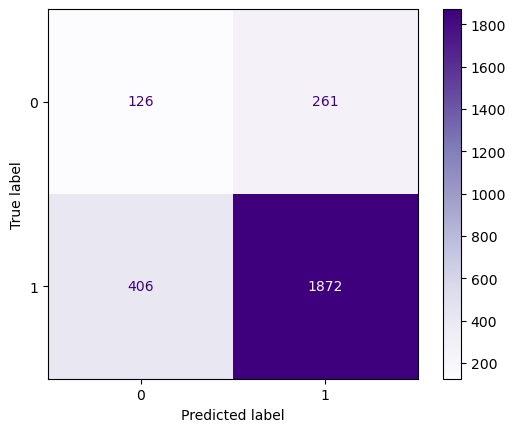

In [219]:
# attempt after smote
ConfusionMatrixDisplay.from_estimator(rf_smote, X_test_ss, y_test,
                                     cmap='Purples');

#### SMOTE Summary
When looking at the classification report, some of the scores, like recall were a bit better with SMOTE.  Before we were seeing recall scores in the high .9x range for the majority class and .0x range for the minority class.  So although this is an improvement over the initial model that was created, overall it wasn't a huge gain in performance and indicates that more feature selection or feature engineering should be done to try and address some of the underlying issues.  If some of the underlying issues could be addressed, then additionally using SMOTE may be a reasonable approach.